In [1]:
include("./trajopt/utils.jl")
include("./trajopt/dynamics.jl")
include("./funlopt/funl_dynamics.jl")
include("./funlopt/funl_utils.jl")
include("./funlopt/funl_constraint.jl")
include("./trajopt/scaling.jl")
include("./funlopt/funl_synthesis.jl")
# using Plots

run (generic function with 1 method)

In [2]:
# load nominal trajectory
using JLD2, FileIO
filename = "./data/unicycle_N15_traj" 
@load filename my_dict
xnom = my_dict["x"]
unom = my_dict["u"]
tnom = my_dict["t"];
N = size(xnom,2) - 1
dtnom = zeros(N)
for i in 1:N
    dtnom[i] = tnom[i+1]-tnom[i]
end

In [3]:
dynamics = Unicycle()
ix = dynamics.ix
iu = dynamics.iu
decay_rate = 0.1
DLMI = NonlinearDLMI(decay_rate,ix,iu,dynamics.Cv,dynamics.Dvu)
is = DLMI.is

1

In [4]:
function get_H_obs(rx,ry)
    return diagm([1/rx,1/ry])
end
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.5,0.5)
push!(c_list,c1)
push!(H_list,H1)
c2 = [4,3]
H2 = get_H_obs(0.5,0.5)
push!(c_list,c2)
push!(H_list,H2)

vmax = 2.0
vmin = 0.0
wmax = 2.0
wmin = -2.0
list_const = [InputConstraint([1;0],vmax),
    InputConstraint([-1;0],-vmin),
    InputConstraint([0; 1],wmax),
    InputConstraint([0; -1],-wmin),
    ObstacleAvoidance(H_list[1],c_list[1]),
    ObstacleAvoidance(H_list[2],c_list[2])
    ]

6-element Vector{FunnelConstraint}:
 InputConstraint([1, 0], 2.0)
 InputConstraint([-1, 0], -0.0)
 InputConstraint([0, 1], 2.0)
 InputConstraint([0, -1], 2.0)
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2])
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])

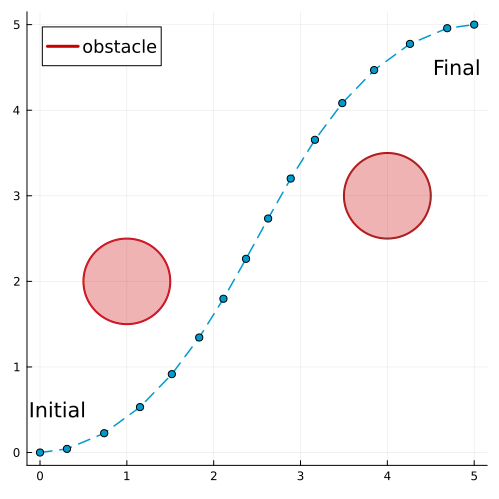

In [5]:
p2 = Plots.plot(; size=(500,500))
plot!(xnom[1,:],xnom[2,:],c=:deepskyblue3,linestyle=:dash,linewidth=1.5,label=nothing)
scatter!(xnom[1,:],xnom[2,:],c=:deepskyblue3,linewidth=1.5,label=nothing)
for (idx,(ce, H)) in enumerate(zip(c_list, H_list))
    label = nothing
    if idx == 1
        label = "obstacle"
    end
    plot_ellipse(p2,inv(H)*inv(H),ce,"red3",label=label)
end
annotate!(0.2, 0.5, text("Initial", :black, :center))
annotate!(4.8, 4.5, text("Final", :black, :center))
display(p2)

In [6]:
@load "./data/unicycle_N15_gamma" my_dict
Lipschitz = my_dict["gamma"]
# Lipschitz = zeros(N+1);

16-element Vector{Float64}:
 0.570571954948126
 0.8308607900113698
 0.844159565287813
 0.8654152957085239
 0.8792184129491256
 0.8687365489650022
 0.5914890127363003
 0.38076391688315914
 0.36437084470729064
 0.43572528000892297
 0.3575909503402617
 0.3402648444649331
 0.38029570329838813
 0.5129076232095225
 0.49656890802460396
 0.21778499063279252

In [7]:
Qnom = zeros(ix,ix,N+1)
Knom = zeros(iu,ix,N+1)
Znom = zeros(ix,ix,N+1);
lamnom = zeros(1,N+1);
nunom = zeros(1,N+1);
Qini = diagm([0.08,0.08,0.06])
Qf = diagm([0.08,0.08,0.06])
for i in 1:N+1
    Qnom[:,:,i] .= Qini
    # Znom[:,:,i] .= 1.0I(ix)
end
# Xnom,Unom = QKZS_to_XU(Qnom,Knom,Znom,vcat(lamnom,nunom))
Xnom,Unom = QKZS_to_XU(Qnom,Knom,Znom,lamnom)
;

In [8]:
xmin = [0;0;0];
xmax = [5;5;pi];
umin = [0;0];
umax = [vmax;wmax];
scaler = Scaling(xmin, xmax, umin, umax, tnom[end],0,0)

Scaling([5.0 0.0 0.0; 0.0 5.0 0.0; 0.0 0.0 3.141592653589793], [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.3183098861837907], [0.0, 0.0, 0.0], [2.0 0.0; 0.0 2.0], [0.5 0.0; 0.0 0.5], [0.0, 0.0], 4.999999999999999, 0.0, 0.0, 2.746533763e-314)

In [9]:
max_iter = 50;
w_funl = 2*1e-2;
w_vc = 1e0;
w_tr::Float64 = 1e0
tol_vc = 1e-6;
tol_tr = 1e-4;
tol_dyn = 1e-1;
verbosity = true;

In [31]:
include("./funlopt/funl_synthesis.jl")

run (generic function with 1 method)

In [32]:
fs = FunnelSynthesis(N,max_iter,dynamics,DLMI,list_const,scaler,
    w_funl,w_vc,w_tr,tol_tr,tol_vc,tol_dyn,verbosity)

FunnelSynthesis(Unicycle(3, 2, 2, 2, 2, 2, [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [1 0; 0 1; 0 0], [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [0.0, 0.0]), NonlinearDLMI(0.1, 3, 2, 6, 6, 1, 6, 13, [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1, 4, 5, 7, 8, 9], sparse([1, 2, 4, 5, 3, 7, 6, 8, 9], [1, 2, 2, 3, 4, 4, 5, 5, 6], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 9, 6)), FunnelConstraint[InputConstraint([1, 0], 2.0), InputConstraint([-1, 0], -0.0), InputConstraint([0, 1], 2.0), InputConstraint([0, -1], 2.0), ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2]), ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])], Scaling([5.0 0.0 0.0; 0.0 5.0 0.0; 0.0 0.0 3.141592653589793], [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.3183098861837907], [0.0, 0.0, 0.0], [2.0 0.0; 0.0 2.0], [0.5 0.0; 0.0 0.5], [0.0, 0.0], 4.999999999999999, 0.0, 0.0, 2.746533763e-314), FunnelSolution([0.0 0.0 … 0.0 0

In [33]:
run(fs,Xnom,Unom,Lipschitz,Qini,Qf,xnom,unom,dtnom,"Mosek")
# run(fs,Xnom,Unom,Lipschitz,Qini,Qf,xnom,unom,dtnom,"Clarabel")

The elapsed time of discretization is: 0.657087875 seconds
The elapsed time of solver is: 0.026446819305419922 seconds
The elapsed time of subproblem is: 0.342130583 seconds
The elapsed time of multiple shooting is: 1.901247375 seconds
+--------------------------------------------------------------------------------------------------+
|                                   ..:: Penalized Trust Region ::..                               |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
| iter. |    cost    |    tof    |   funl    |   rate    |  param  | log(vc) | log(tr)  | log(dyn) |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
|1      |8.11        |-1.000    |5.297      |-1.000     |-1.000    |0.4      | 0.7      |-1.9e-01   |
The elapsed time of discretization is: 0.131683833 seconds
The elapsed time of solver is: 0.030904054641723633 seconds
The elapsed time of subproblem is: 0.0

In [34]:
tprop,xprop,uprop = fs.solution.tprop,fs.solution.xprop,fs.solution.uprop
Xprop,Uprop = fs.solution.Xprop,fs.solution.Uprop
Qprop,Kprop,Zprop,Sprop = XU_to_QKZS(Xprop,Uprop,ix,iu)
Qnode,Knode,Znode,Snode = XU_to_QKZS(fs.solution.X,fs.solution.U,ix,iu)

([1.204150921037051 -0.24558540801789056 0.294410196693934; -0.24558540801789056 1.1567643320085526 -0.644928073279081; 0.294410196693934 -0.644928073279081 1.0437517371087417;;; 1.1336822967788962 -0.22447045179561576 0.3850795894194903; -0.22447045179561576 1.095592550249307 -0.6183860974309856; 0.3850795894194903 -0.6183860974309856 0.8214744061401756;;; 1.0734967580331634 -0.1256260272103728 0.4585722464237219; -0.1256260272103728 0.9204237242889762 -0.5744635098042656; 0.4585722464237219 -0.5744635098042656 0.7919956292498957;;; … ;;; 0.18260721921517759 0.05560456435491873 -0.04217382386735828; 0.05560456435491873 0.18415111741848125 -0.23305090485517566; -0.04217382386735828 -0.23305090485517566 0.3595768914210521;;; 0.15565389037437222 0.020869750909869526 -0.025010294228597872; 0.020869750909869526 0.08112128250190213 -0.11675883298569648; -0.025010294228597872 -0.11675883298569648 0.3289360982606025;;; 0.07999997089030207 -3.25078857003753e-8 -1.5424719368950722e-7; -3.250788

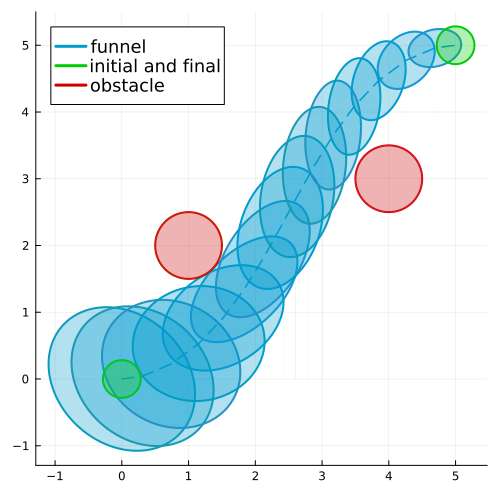

In [35]:
p2 = Plots.plot(; size=(500,500))
plot!(xnom[1,:],xnom[2,:],aspect_ratio=:equal,c=:deepskyblue3,linestyle=:dash,linewidth=1.5,label=nothing)
for idx in 1:N
    label = nothing
    if idx == 1
        label = "funnel"
    end
    plot_ellipse(p2,Qnode[:,:,idx],xnom[:,idx],"deepskyblue3",label=label)
end
plot_ellipse(p2,fs.solution.Qi,xnom[:,1],"green3",label="initial and final")
plot_ellipse(p2,fs.solution.Qf,xnom[:,end],"green3")
for (idx,(ce, H)) in enumerate(zip(c_list, H_list))
    label = nothing
    if idx == 1
        label = "obstacle"
    end
    plot_ellipse(p2,inv(H)*inv(H),ce,"red3",label=label)
end
display(p2)
# savefig("./data_image/funnel_unicycle.pdf")

In [36]:
min_lam_qprop = zeros(size(Qprop,3))
for i in 1:size(Qprop,3)
    eigvals = eigen(Qprop[:,:,i]).values
    min_lam_qprop[i] = eigvals[1]
end
min_lam_q = zeros(size(Qnode,3))
for i in 1:size(Qnode,3)
    eigvals = eigen(Qnode[:,:,i]).values
    min_lam_q[i] = eigvals[1]
end

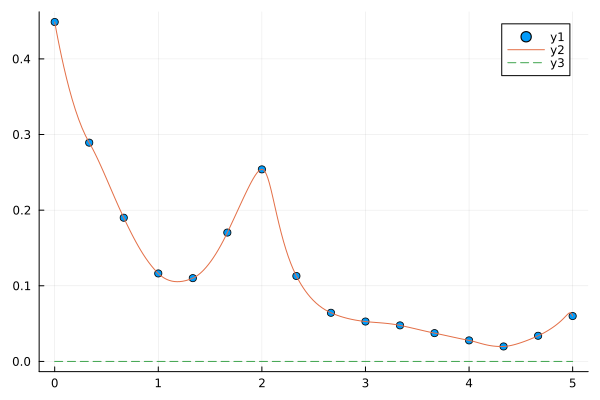

In [37]:
scatter(tnom,min_lam_q,seriestype="o")
plot!(tprop,min_lam_qprop)
plot!(tnom,tnom .* 0,linestyle=:dash)

In [38]:
findfirst(x -> x < 0, min_lam_q)

# input funnel

In [39]:
function project_onto_input(Q,K) 
    R = []
    for i in 1:size(Q,3)
        K_ = K[:,:,i]
        push!(R,K_*Q[:,:,i]*K_')
    end
    projected_input_funl = []
    for j in 1:iu
        a = zeros(iu)
        a[j] = 1
        each_funl = []
        for i in 1:length(R)
            push!(each_funl,sqrt(a'*R[i]*a))
        end
        push!(projected_input_funl,each_funl)
    end
    return projected_input_funl
end

project_onto_input (generic function with 1 method)

In [40]:
input_proj_funl_nom = project_onto_input(Qnode,Knode)
input_proj_funl_prop = project_onto_input(Qprop,Kprop)

2-element Vector{Any}:
 Any[0.5738348772349912, 0.5755649930368799, 0.5787968650911687, 0.5827613965713155, 0.5877562940544833, 0.593650604656804, 0.6005518895814681, 0.6084037953366307, 0.6172276109557475, 0.6269769302928268  …  0.6203719907268137, 0.6141071988178399, 0.6084740722766561, 0.6029164826052764, 0.5975114005392682, 0.5921433856825703, 0.5868149410199646, 0.5814813432074695, 0.5761280010655758, 0.5748834328222272]
 Any[1.404868663043124, 1.3946644244672255, 1.3762602173980671, 1.354788604684608, 1.3293439447751707, 1.3014292730120027, 1.271374918955254, 1.2402722445839327, 1.2088119251939509, 1.1778526486894865  …  1.240191540467647, 1.2579951100544748, 1.2756401103525197, 1.2950390378546592, 1.3160280434428266, 1.3389687839795401, 1.3636681561257047, 1.39005563156621, 1.4178694448765323, 1.4244918392315062]

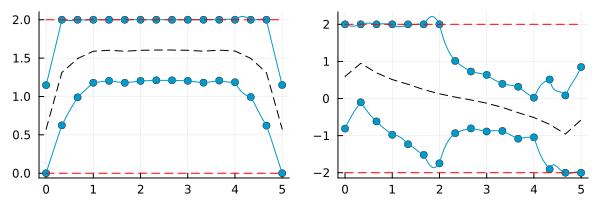

In [41]:
p1 = plot(tnom,unom[1,:],linestyle=:dash,color="black",label="")
scatter!(tnom,unom[1,:]+input_proj_funl_nom[1],color="deepskyblue3",label="")
scatter!(tnom,unom[1,:]-input_proj_funl_nom[1],color="deepskyblue3",label="")
plot!(tprop,uprop[1,:]+input_proj_funl_prop[1],color="deepskyblue3",label="")
plot!(tprop,uprop[1,:]-input_proj_funl_prop[1],color="deepskyblue3",label="")
plot!(tnom,tnom*0 .+ vmax,linestyle=:dash,color="red",label="")
plot!(tnom,tnom*0 .+ vmin,linestyle=:dash,color="red",label="")
p2 = plot(tnom,unom[2,:],linestyle=:dash,color="black",label="")
scatter!(tnom,unom[2,:]+input_proj_funl_nom[2],color="deepskyblue3",label="")
scatter!(tnom,unom[2,:]-input_proj_funl_nom[2],color="deepskyblue3",label="")
plot!(tprop,uprop[2,:]+input_proj_funl_prop[2],color="deepskyblue3",label="")
plot!(tprop,uprop[2,:]-input_proj_funl_prop[2],color="deepskyblue3",label="")
plot!(tnom,tnom*0 .+ wmax,linestyle=:dash,color="red",label="")
plot!(tnom,tnom*0 .+ wmin,linestyle=:dash,color="red",label="")
plot(p1,p2,layout=(1,2),size=(600,200))

In [42]:
using Random
using LinearAlgebra

In [43]:
include("./funlopt/funl_utils.jl")

QKZS_to_XU (generic function with 1 method)

In [44]:
xs_list = []
for i in 1:50
    z = randn(ix)
    z = z / norm(z)
    push!(xs_list,xnom[:,1] + sqrt(Qnode[:,:,1]) * z)
end

In [45]:
xsam_fwd,tsam,xsam,usam = [],[],[],[]
xnom_sam = []
for xs in xs_list
    xf_,ts_,xsam_,usam_,_ = propagate_from_funnel_entry(xs,DLMI,dynamics,xnom,unom,dtnom,Knode)
    push!(xsam_fwd,xf_)
    push!(tsam,ts_)
    push!(xsam,xsam_)
    push!(usam,usam_)
    # push!(xnom_sam,xnom_)
end

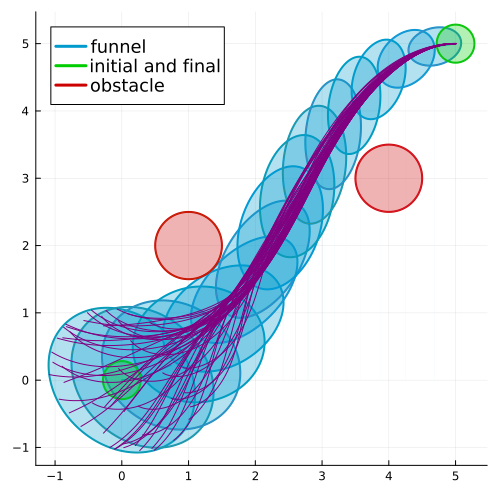

In [46]:
p2 = Plots.plot(; size=(500,500))
plot!(xnom[1,:],xnom[2,:],c=:deepskyblue3,linestyle=:dash,linewidth=1.5,label=nothing)
for idx in 1:N
    label = nothing
    if idx == 1
        label = "funnel"
    end
    plot_ellipse(p2,Qnode[:,:,idx],xnom[:,idx],"deepskyblue3",label=label)
end
plot_ellipse(p2,fs.solution.Qi,xnom[:,1],"green3",label="initial and final")
plot_ellipse(p2,fs.solution.Qf,xnom[:,end],"green3")
for (idx,(ce, H)) in enumerate(zip(c_list, H_list))
    label = nothing
    if idx == 1
        label = "obstacle"
    end
    plot_ellipse(p2,inv(H)*inv(H),ce,"red3",label=label)
end
for x_ in xsam
    plot!(x_[1,:],x_[2,:],color="purple",label=nothing)
end
display(p2)

# Lipschitz constant estimation

In [ ]:
# input funnel
Rnode = []
for i in 1:size(Qnode,3)
    K_ = Knode[:,:,i]
    push!(Rnode,K_*Qnode[:,:,i]*K_')
end

In [ ]:
gamma_est = Lipschitz_estimation_around_traj(N,100,xnom,unom,dynamics,Qnode,Rnode)

In [ ]:
# using JLD2, FileIO
# my_dict = Dict("gamma" => gamma_est)
# @save "./data/unicycle_N15_gamma" my_dict